## 1 LOAD THE LIBRARY

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2024-08-15 13:25:29.173273: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 13:25:29.173324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 13:25:29.174739: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 13:25:29.183407: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 13:25:30.184838: W tensorflow/compiler/tf2

In [2]:
# Define paths
base_path = '/home/ubuntu/BTS/Breast_Cancer_Segmentation/Mass_Data'
benign_path = os.path.join(base_path, 'Benign')
malignant_path = os.path.join(base_path, 'Malignant')

# Parameters
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

# Function to load images and masks
def load_data(img_folder, mask_folder):
    images = []
    masks = []
    for filename in os.listdir(img_folder):
        if filename.endswith(".png") and not "_MASK" in filename:
            img = load_img(os.path.join(img_folder, filename), target_size=(IMG_HEIGHT, IMG_WIDTH))
            img = img_to_array(img)  # No normalization here
            
            # Adjust the mask file name according to the actual naming pattern
            mask_name = filename.replace(".png", "_MASK.png")
            
            # Check if the mask file exists
            mask_path = os.path.join(mask_folder, mask_name)
            if not os.path.exists(mask_path):
                print(f"Warning: Mask file {mask_path} not found for image {filename}")
                continue

            mask = load_img(mask_path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale")
            mask = img_to_array(mask) / 255.0  # Normalize mask to [0, 1]
            images.append(img)
            masks.append(mask)
    
    images = np.array(images) / 255.0  # Normalize images to [0, 1] range
    return images, np.array(masks)

# Load Benign data
benign_images, benign_masks = load_data(benign_path, benign_path)

# Load Malignant data
malignant_images, malignant_masks = load_data(malignant_path, malignant_path)

# Combine data
images = np.concatenate((benign_images, malignant_images), axis=0)
masks = np.concatenate((benign_masks, malignant_masks), axis=0)


#### Preview the Images

In [3]:
# import cv2

# # Function to display an image and mask using cv2
# def preview_with_cv2(image, mask):
#     # Convert the image back to the [0, 255] range and to uint8
#     image = (image * 255).astype(np.uint8)
    
#     # If the image has 3 channels, ensure it's in the correct format
#     if image.shape[-1] == 3:
#         image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
#     # Convert the mask back to [0, 255] and to uint8
#     mask = (mask * 255).astype(np.uint8)
    
#     # Display image and mask
#     cv2.imshow('Image', image)
#     cv2.imshow('Mask', mask)
    
#     # Wait for a key press and then close the windows
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

# # Preview a sample image and mask
# preview_with_cv2(images[0], masks[0])


In [4]:
# Split the data into training, validation, and testing sets
X_train, X_temp, Y_train, Y_temp = train_test_split(images, masks, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Data augmentation
data_gen_args = dict(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

# Create augmented data generators
train_image_generator = image_datagen.flow(X_train, batch_size=32, seed=42)
train_mask_generator = mask_datagen.flow(Y_train, batch_size=32, seed=42)
val_image_generator = image_datagen.flow(X_val, batch_size=32, seed=42)
val_mask_generator = mask_datagen.flow(Y_val, batch_size=32, seed=42)

# Combine generators into one which yields image and mask
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)


### U_net Model Architecture

In [5]:

# Build U-Net Model
def unet_model(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    # Contracting path
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)
    
    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    
    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)
    
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bottleneck
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, 3, activation='relu', padding='same')(c5)
    
    # Expanding path
    u6 = UpSampling2D(size=(2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(512, 3, activation='relu', padding='same')(c6)
    
    u7 = UpSampling2D(size=(2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(256, 3, activation='relu', padding='same')(c7)
    
    u8 = UpSampling2D(size=(2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, 3, activation='relu', padding='same')(u8)
    c8 = Conv2D(128, 3, activation='relu', padding='same')(c8)
    
    u9 = UpSampling2D(size=(2, 2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, 3, activation='relu', padding='same')(u9)
    c9 = Conv2D(64, 3, activation='relu', padding='same')(c9)
    
    outputs = Conv2D(1, 1, activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Instantiate the model
model = unet_model()



2024-08-15 13:27:01.935343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-15 13:27:02.727669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-15 13:27:02.727942: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
# Train the model with augmented data and validation set
history = model.fit(train_generator, 
                    steps_per_epoch=len(X_train) // 32, 
                    epochs=50, 
                    validation_data=val_generator, 
                    validation_steps=len(X_val) // 32)


Epoch 1/50


2024-08-15 13:27:56.169460: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-08-15 13:27:56.844911: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-15 13:28:02.841122: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-08-15 13:28:04.053030: I external/local_xla/xla/service/service.cc:168] XLA service 0x7699950d0340 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-15 13:28:04.053070: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-08-15 13:28:04.088592: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1723728484.267897    2222 device_compiler.h:1

42/42 [==============================] - 32s 194ms/step - loss: 1.7811 - accuracy: 0.7197 - val_loss: 0.5797 - val_accuracy: 0.7785
Epoch 2/50
42/42 [==============================] - 21s 216ms/step - loss: 0.5482 - accuracy: 0.7238 - val_loss: 0.4648 - val_accuracy: 0.7479
Epoch 3/50
42/42 [==============================] - 7s 172ms/step - loss: 0.4105 - accuracy: 0.7895 - val_loss: 0.4017 - val_accuracy: 0.7927
Epoch 4/50
42/42 [==============================] - 7s 159ms/step - loss: 0.3865 - accuracy: 0.8054 - val_loss: 0.3722 - val_accuracy: 0.8123
Epoch 5/50
42/42 [==============================] - 7s 156ms/step - loss: 0.3778 - accuracy: 0.8089 - val_loss: 0.3692 - val_accuracy: 0.8124
Epoch 6/50
42/42 [==============================] - 6s 155ms/step - loss: 0.3758 - accuracy: 0.8099 - val_loss: 0.3899 - val_accuracy: 0.8027
Epoch 7/50
42/42 [==============================] - 7s 156ms/step - loss: 0.3787 - accuracy: 0.8081 - val_loss: 0.3653 - val_accuracy: 0.8162
Epoch 8/50
42/4

#### Visualizing the model performance 

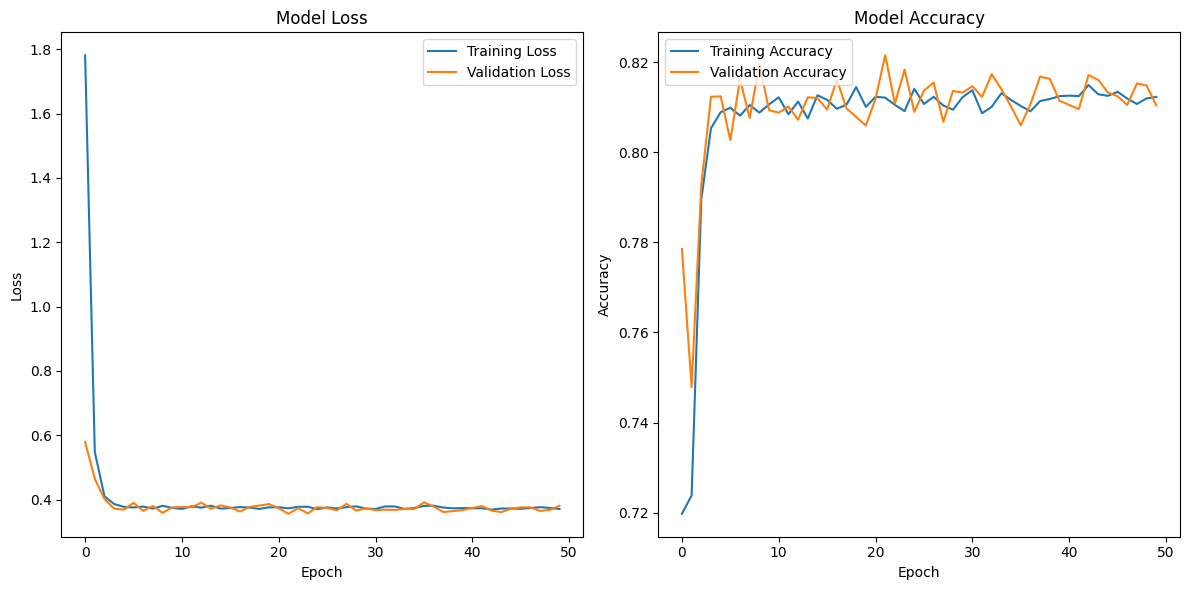

In [7]:
# Plot training history
def plot_history(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    
    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Visualize the history
plot_history(history)


In [8]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


10/10 [==============================] - 2s 256ms/step - loss: 0.3456 - accuracy: 0.8579
Test Loss: 0.345609575510025
Test Accuracy: 0.8579343557357788


1/1 [==============================] - 2s 2s/step


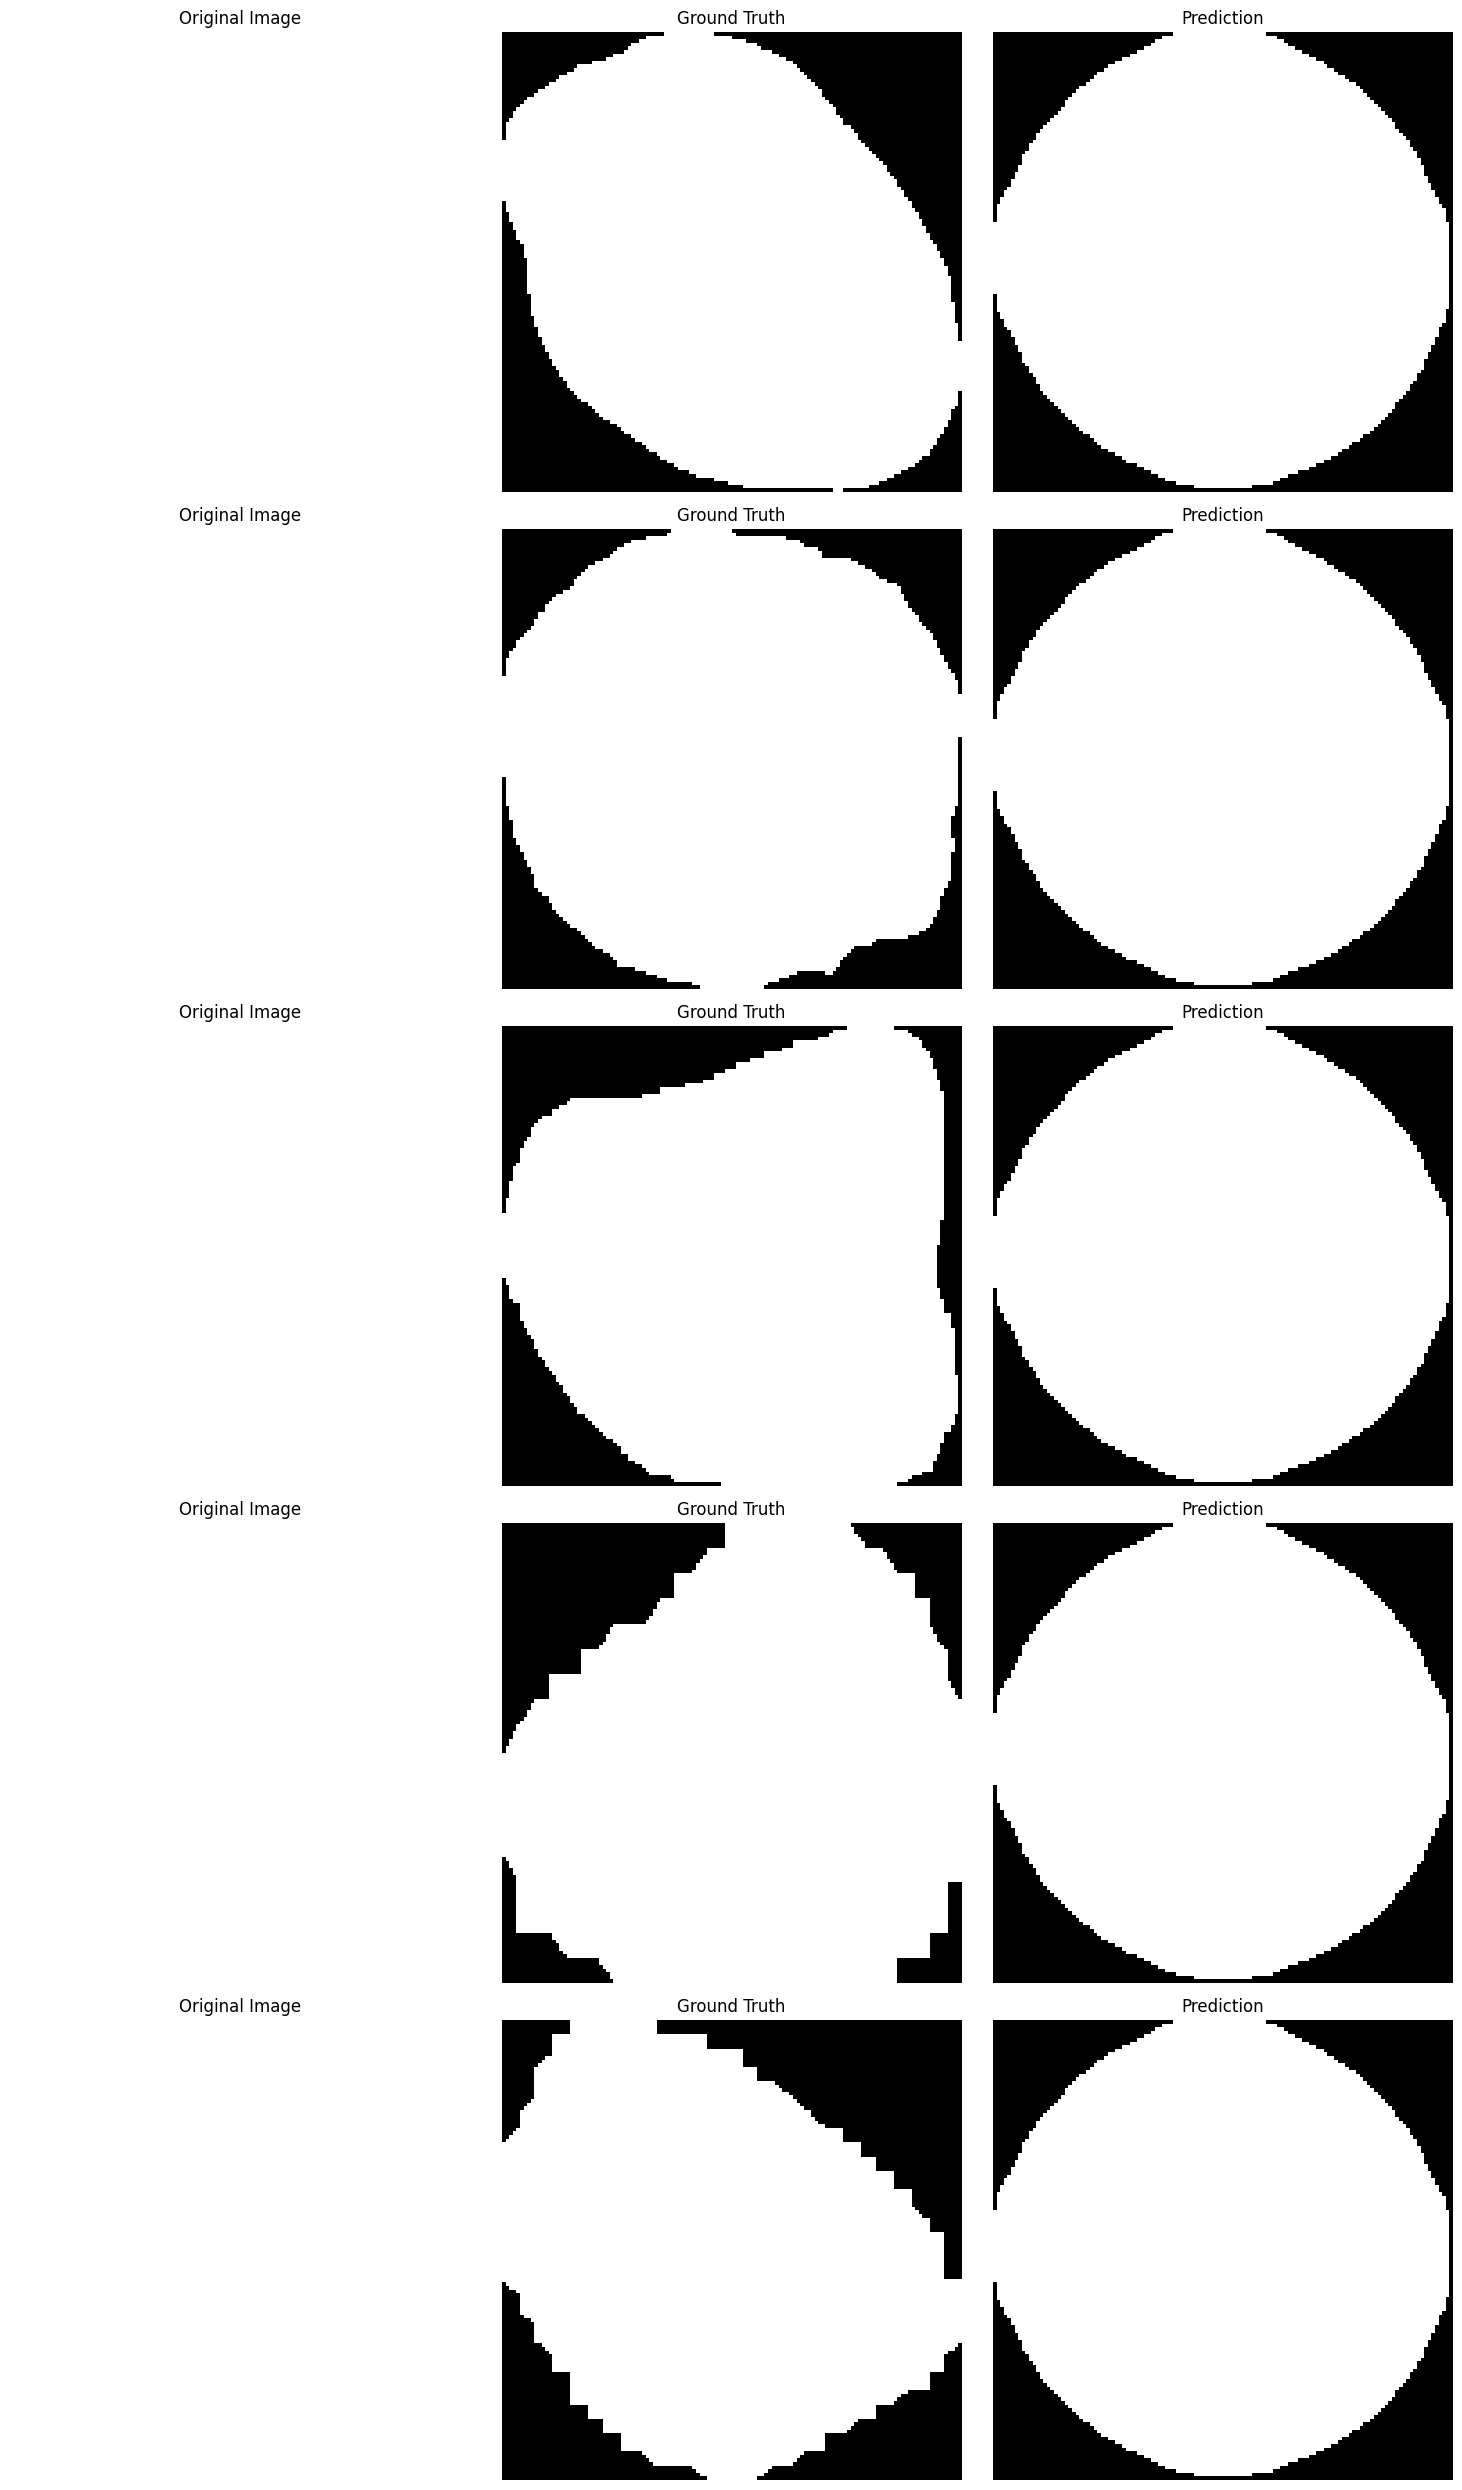

In [9]:
# Visualize predictions on the test set
def plot_predictions(model, X_test, Y_test, num=5, threshold=0.5):
    predictions = model.predict(X_test[:num])
    plt.figure(figsize=(15, num * 5))
    
    for i in range(num):
        plt.subplot(num, 3, i*3 + 1)
        
        # Normalize if necessary
        if X_test[i].max() > 1:
            X_test[i] = X_test[i] / 255.0
        
        if X_test[i].shape[-1] == 3:  # RGB Image
            plt.imshow(X_test[i])
        else:
            plt.imshow(X_test[i].squeeze(), cmap='gray')
        
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow(Y_test[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')
        
        plt.subplot(num, 3, i*3 + 3)
        predicted_mask = (predictions[i].squeeze() > threshold).astype(np.uint8)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Prediction')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_predictions(model, X_test, Y_test)



1/1 [==============================] - 0s 22ms/step


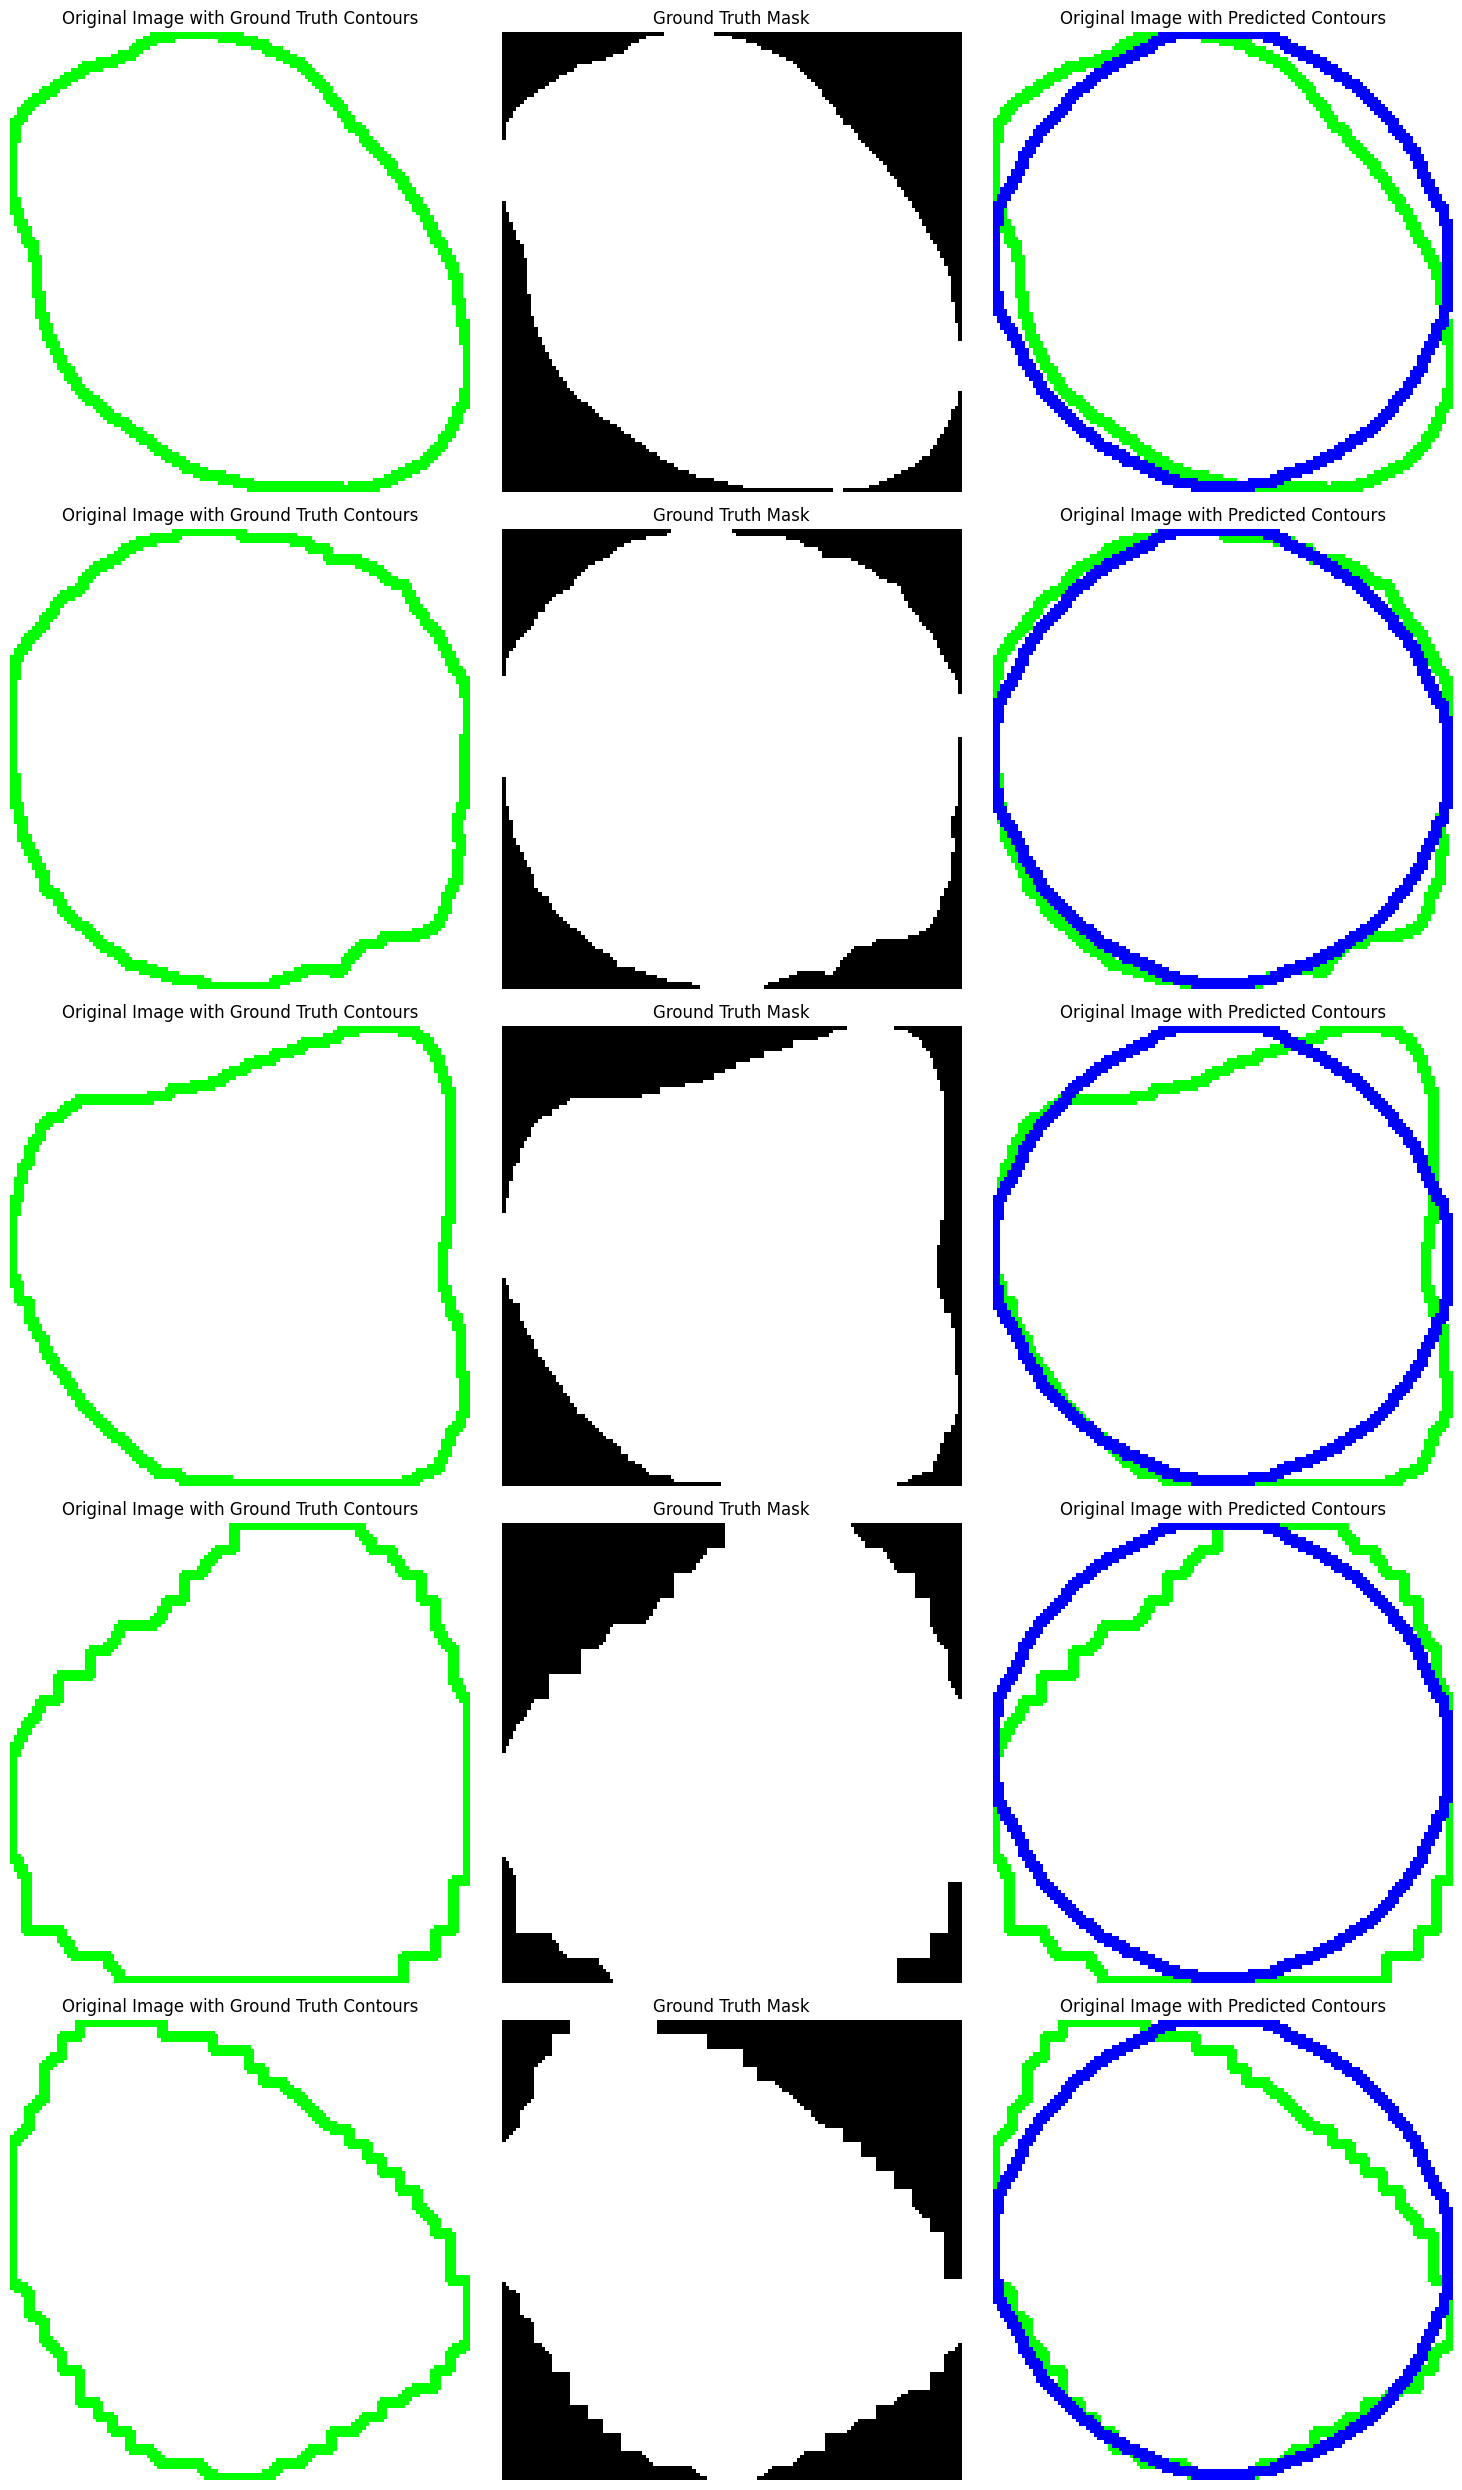

In [10]:
import cv2

def plot_predictions_with_contours(model, X_test, Y_test, num=5, threshold=0.5):
    predictions = model.predict(X_test[:num])
    plt.figure(figsize=(15, num * 5))
    
    for i in range(num):
        # Prepare the original image
        original_image = X_test[i].copy()
        if original_image.max() > 1:
            original_image = original_image / 255.0
        
        # Convert to BGR for contour drawing if necessary
        if original_image.shape[-1] == 3:  # RGB Image
            original_image_bgr = cv2.cvtColor((original_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        else:  # Grayscale image
            original_image_bgr = cv2.cvtColor((original_image.squeeze() * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        
        # Ground truth mask
        ground_truth_mask = (Y_test[i].squeeze() * 255).astype(np.uint8)
        
        # Predicted mask
        predicted_mask = (predictions[i].squeeze() > threshold).astype(np.uint8) * 255
        
        # Find contours in the ground truth mask
        contours_gt, _ = cv2.findContours(ground_truth_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(original_image_bgr, contours_gt, -1, (0, 255, 0), 2)  # Green contours for ground truth
        
        # Find contours in the predicted mask
        contours_pred, _ = cv2.findContours(predicted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        predicted_image_bgr = original_image_bgr.copy()  # Copy to draw predicted contours separately
        cv2.drawContours(predicted_image_bgr, contours_pred, -1, (255, 0, 0), 2)  # Blue contours for prediction
        
        # Plot original image with ground truth contours
        plt.subplot(num, 3, i*3 + 1)
        plt.imshow(cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB))
        plt.title('Original Image with Ground Truth Contours')
        plt.axis('off')
        
        # Plot ground truth mask
        plt.subplot(num, 3, i*3 + 2)
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Plot original image with predicted contours
        plt.subplot(num, 3, i*3 + 3)
        plt.imshow(cv2.cvtColor(predicted_image_bgr, cv2.COLOR_BGR2RGB))
        plt.title('Original Image with Predicted Contours')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot predictions with contours
plot_predictions_with_contours(model, X_test, Y_test)


#### Interpretation:
- Contour Alignment:
The green contours represent the true boundaries of the tumor, based on the ground truth segmentation.
The blue contours represent the predicted boundaries of the tumor, based on the model's predictions.

- Comparing Predictions to Ground Truth:
In some examples, the blue predicted contours closely align with the green ground truth contours, indicating that the model has accurately segmented the tumor.
In other examples, there are noticeable differences between the blue and green contours, indicating that the model's predictions are not perfectly matching the ground truth. These differences could suggest areas where the model might need further tuning or where the data might be more challenging.

- Prediction Quality:
Top Rows: The predicted contours (blue) mostly follow the ground truth contours (green), though there are some slight misalignments, particularly at the edges.
Middle Rows: The model predictions seem to be fairly accurate, with the blue contours aligning well with the green contours, although there are minor deviations.
Bottom Rows: There is a noticeable discrepancy between the predicted and ground truth contours in some of the images, indicating that the model may have had difficulties with these specific cases.

- Observations:
Overall Performance: The model appears to perform well in most cases, as indicated by the close alignment of the blue and green contours. However, slight deviations suggest that the model might benefit from further optimization or additional training data.
Potential Improvements: The images where the blue contours deviate more significantly from the green contours could point to areas where the model struggles. These cases might require more attention during training or further refinement of the model architecture.

1/1 [==============================] - 0s 22ms/step


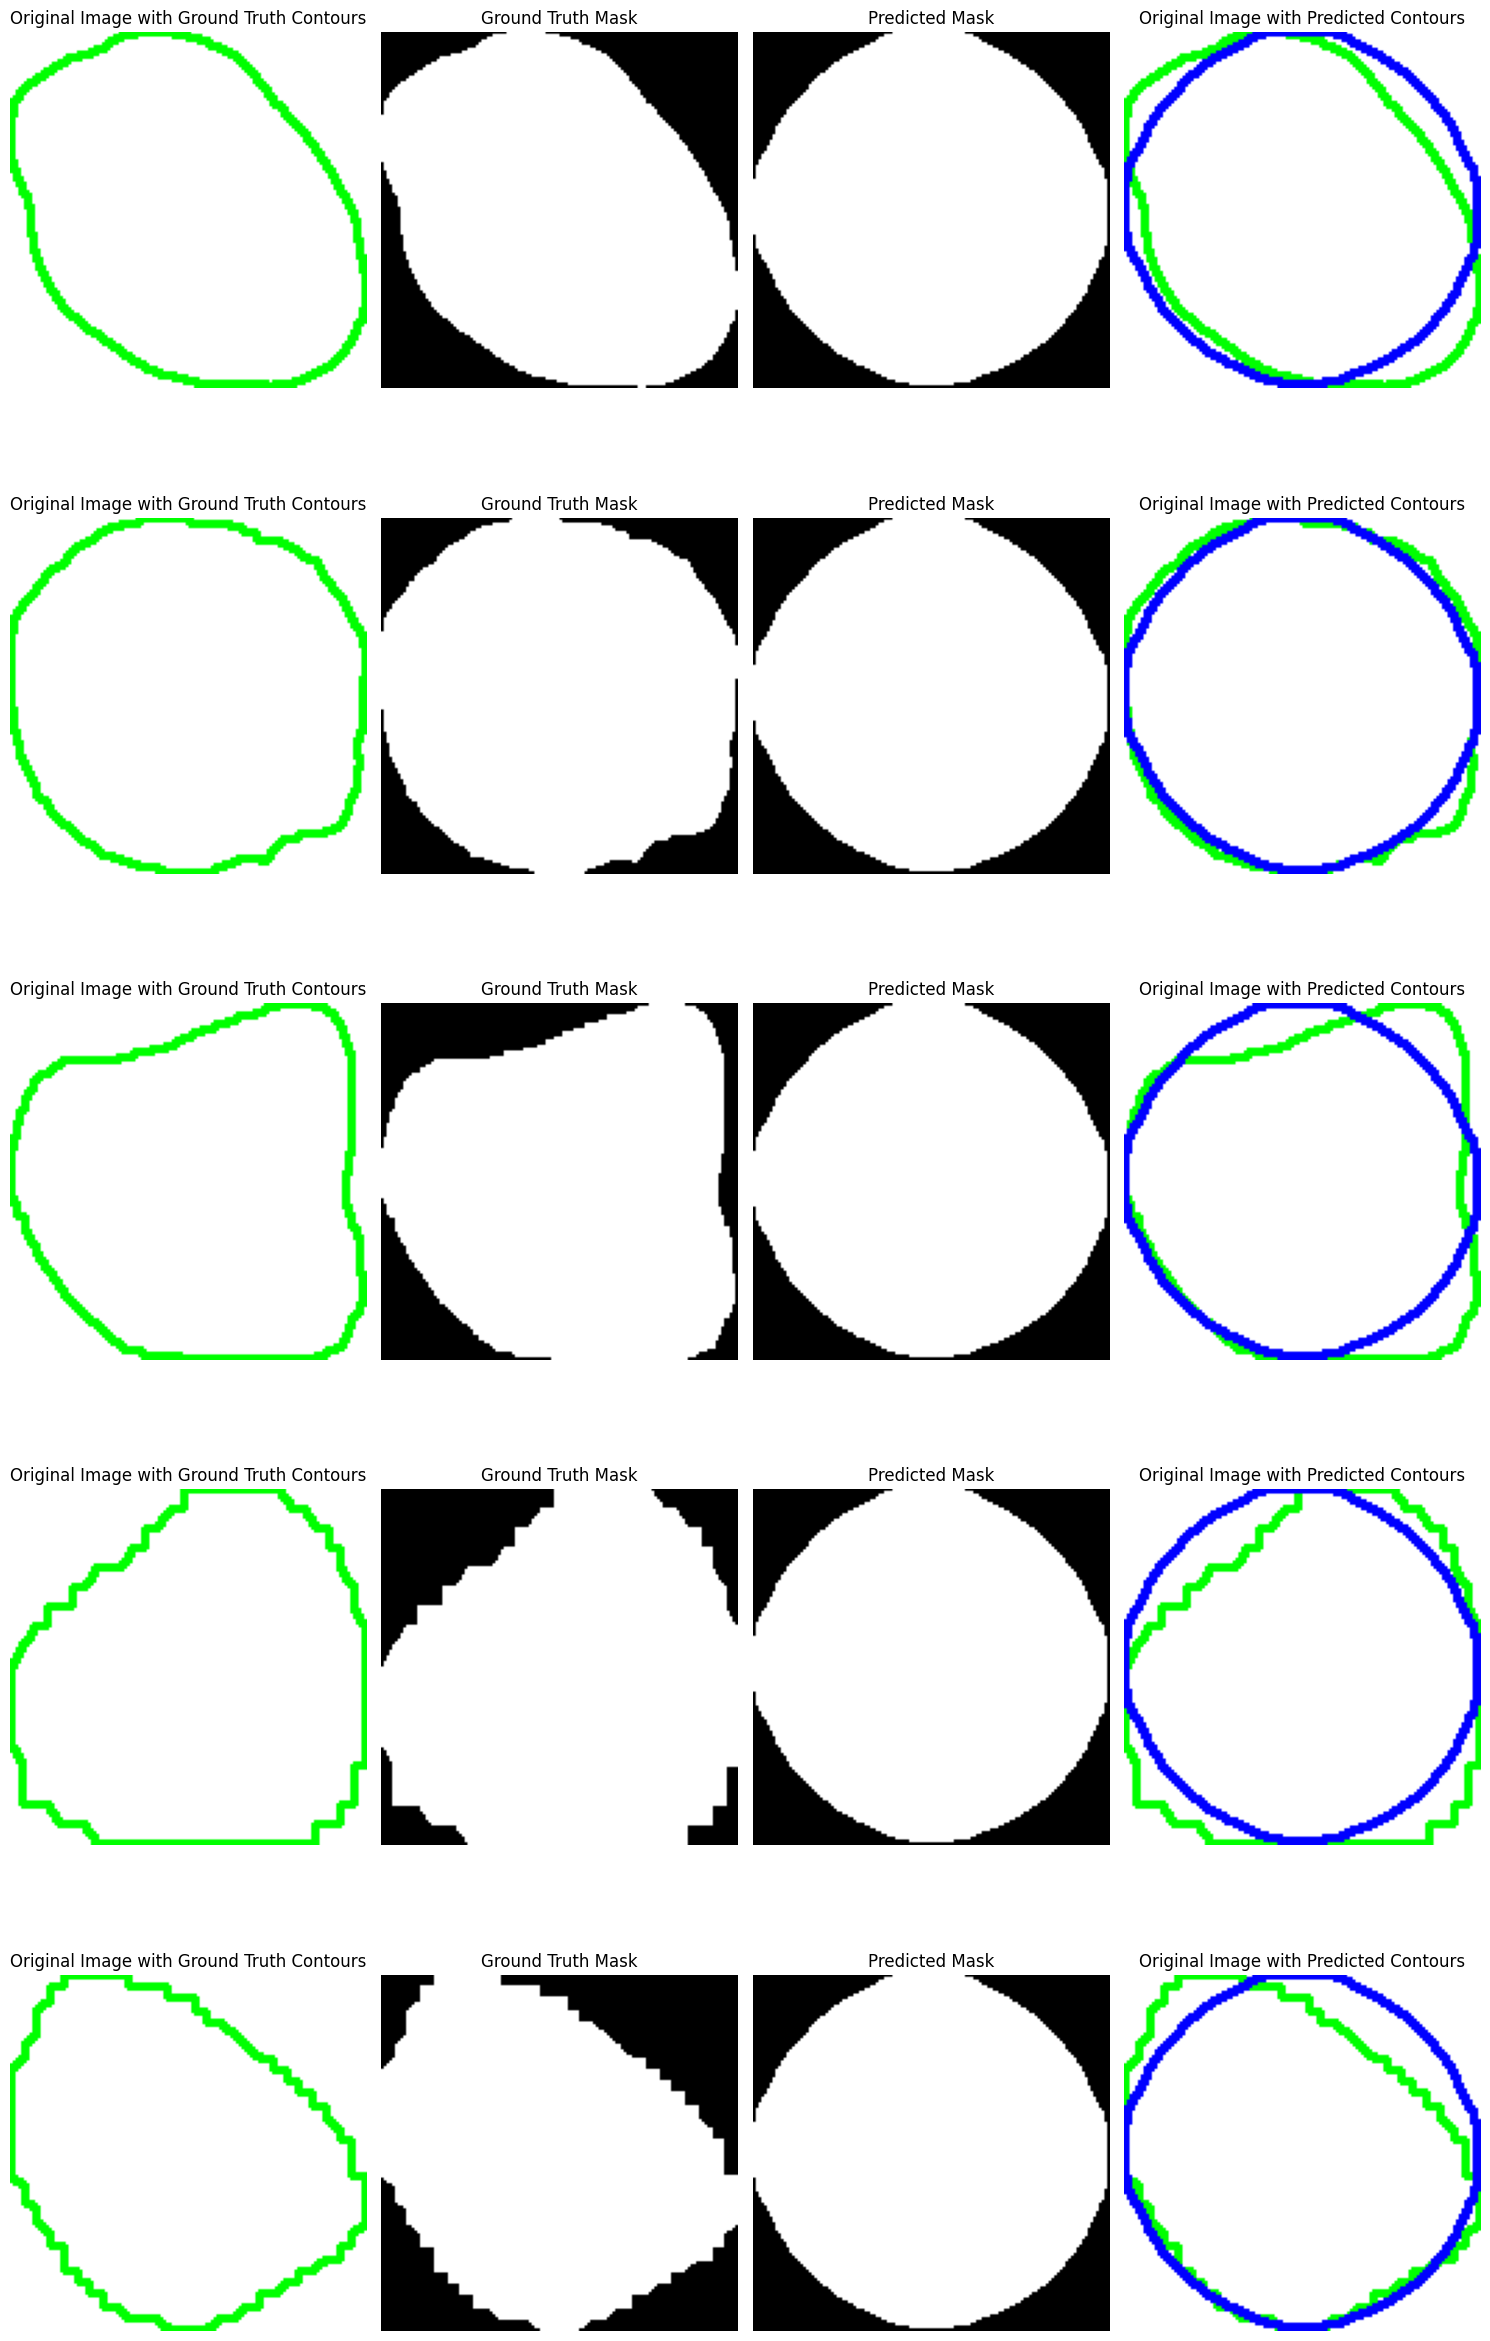

In [14]:
import cv2
import matplotlib.pyplot as plt

def plot_predictions_with_contours_and_masks(model, X_test, Y_test, num=5, threshold=0.5):
    predictions = model.predict(X_test[:num])
    plt.figure(figsize=(15, num * 5))
    
    for i in range(num):
        # Prepare the original image
        original_image = X_test[i].copy()
        if original_image.max() > 1:
            original_image = original_image / 255.0
        
        # Convert to BGR for contour drawing if necessary
        if original_image.shape[-1] == 3:  # RGB Image
            original_image_bgr = cv2.cvtColor((original_image * 255).astype(np.uint8), cv2.COLOR_RGB2BGR)
        else:  # Grayscale image
            original_image_bgr = cv2.cvtColor((original_image.squeeze() * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
        
        # Ground truth mask
        ground_truth_mask = (Y_test[i].squeeze() * 255).astype(np.uint8)
        
        # Predicted mask
        predicted_mask = (predictions[i].squeeze() > threshold).astype(np.uint8) * 255
        
        # Find contours in the ground truth mask
        contours_gt, _ = cv2.findContours(ground_truth_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(original_image_bgr, contours_gt, -1, (0, 255, 0), 2)  # Green contours for ground truth
        
        # Find contours in the predicted mask
        contours_pred, _ = cv2.findContours(predicted_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        predicted_image_bgr = original_image_bgr.copy()  # Copy to draw predicted contours separately
        cv2.drawContours(predicted_image_bgr, contours_pred, -1, (255, 0, 0), 2)  # Blue contours for prediction
        
        # Plot original image with ground truth contours
        plt.subplot(num, 4, i*4 + 1)
        plt.imshow(cv2.cvtColor(original_image_bgr, cv2.COLOR_BGR2RGB))
        plt.title('Original Image with Ground Truth Contours')
        plt.axis('off')
        
        # Plot ground truth mask
        plt.subplot(num, 4, i*4 + 2)
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')
        
        # Plot predicted mask
        plt.subplot(num, 4, i*4 + 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')
        
        # Plot original image with predicted contours
        plt.subplot(num, 4, i*4 + 4)
        plt.imshow(cv2.cvtColor(predicted_image_bgr, cv2.COLOR_BGR2RGB))
        plt.title('Original Image with Predicted Contours')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot predictions with contours and masks
plot_predictions_with_contours_and_masks(model, X_test, Y_test)


In [12]:
# Save the model
model.save('Main_data_unet_model.h5')

/home/ubuntu/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
